# Laplace's Equations in 1 Dimension 

## Author
James John 

## Purpose
To demonstrate understanding of electrostatics physics and computational modeling by solving Laplace's Equations in 1 dimension both numerically and analytically 

## Goals 
- Derive Laplace's Equations from Maxwell's Equations in 1 D 
- Derive analytical solutions for a 1 D case
- Create a finite-difference numerical solver for 1D-Laplace's Equation
- Comparison between analytical and numerical solutions
- Visualizations of potential and electric fields 

## Derivation of Laplace's Equation from Maxwell's Equations

We start from **Maxwell's equations** in differential form (in vacuum):

$$
\nabla \cdot \mathbf{E} = \frac{\rho}{\varepsilon_0}, \qquad
\nabla \times \mathbf{E} = -\frac{\partial \mathbf{B}}{\partial t}.
$$

For *electrostatic* conditions, the fields are time-independent, so

$$
\frac{\partial \mathbf{B}}{\partial t} = 0 \quad \Rightarrow \quad \nabla \times \mathbf{E} = 0.
$$

A vector field with zero curl can be written as the negative gradient of a scalar potential $V(r)$ such that:

$$
\mathbf{E} = -\nabla V.
$$

Substitute into Gauss's law:

$$
\nabla \cdot \mathbf{E} = \nabla \cdot (-\nabla V) = -\nabla^2 V = \frac{\rho}{\varepsilon_0}.
$$

This is **Poisson's equation**:

$$
\nabla^2 V = -\frac{\rho}{\varepsilon_0}.
$$

In a region with no free charge $(\rho = 0)$, we obtain **Laplace's equation**:

$$
\boxed{\nabla^2 V = 0.}
$$

## Analytical Solution For a Parallel-Plate Capacitor

We consider two infinite, parallel conducting plates separated by a distance, $ d $. 
The potential difference between them is $ V_0 $, such that:

$$
V(0) = 0, \quad V(d) = V_0
$$

Since the region between the plates is charge-free, we start from **Laplace's equation**:

$$
\nabla^2 V = 0
$$

In one dimension (variation only in $ x $:

$$
\frac{d^2 V}{dx^2} = 0
$$

Integrating once:

$$
\frac{dV}{dx} = A
$$

Integrating again:

$$
V(x) = A x + B
$$

We now apply the boundary conditions.

At $ x = 0 $:
$$
V(0) = 0 = A(0) + B \Rightarrow B = 0
$$

At $ x = d $:
$$
V(d) = V_0 = A d + 0 \Rightarrow A = \frac{V_0}{d}
$$

Substituting $ A $ and $ B $ into our expression for $ V(x) $:

$$
\boxed{V(x) = V_0 \frac{x}{d}}
$$

Finally, the electric field is given by the negative gradient of the potential:

$$
E_x = -\frac{dV}{dx} = -\frac{V_0}{d}
$$

which is **uniform** between the plates, as expected for an ideal parallel-plate capacitor.

## Display of Analytical Solution For a Parallel-Plate Capacitor

In [1]:
# Import all needed libraries 
import numpy as np 
import matplotlib.pyplot as plt
from time import time

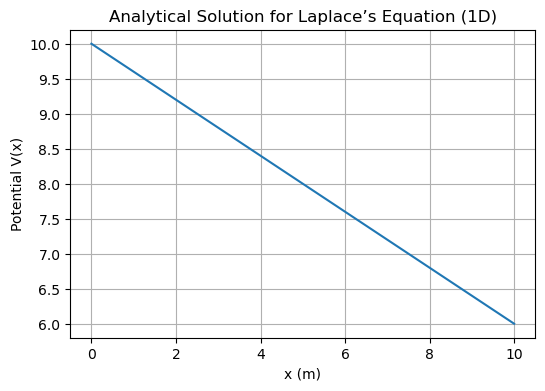

In [2]:
# Physical parameters
d = 10     # distance between plates (m)
V_0 = 10   # potential at x=0
V_d = 6   # potential at x=d
N = 101   # number of points on the grid

# Create a grid of points that go from 0 to d 
x = np.linspace(0, d, N)

# Analytical solution: V(x) = V_0 * x/d = V(x) = V_0 + (V_d - V_0) * x / d
V_exact = V_0 + (V_d - V_0) * x / d

# Plot the analytic potential
plt.figure(figsize=(6,4))
plt.plot(x, V_exact)
plt.xlabel('x (m)')
plt.ylabel('Potential V(x)')
plt.title('Analytical Solution for Laplace’s Equation (1D)')
plt.grid(True)
plt.show()

## Numerical Solution: Jacobi Iteration for Laplace's Equation (1D)

We are going to solve Laplace's Equation in 1D:

$$
\frac{d^2 V}{dx^2} = 0
$$

To do this we can use the **Jacobi iterative method**.  
We first discretize the domain $ x \in [0, d] $ into $ N $ equally spaced points:

$$
x_i = i \, \Delta x, \quad \text{where} \quad \Delta x = \frac{d}{N - 1}.
$$

Using the central difference approximation for the second derivative,

$$
\frac{V_{i+1} - 2V_i + V_{i-1}}{(\Delta x)^2} = 0,
$$

we can rearrange to get the **update rule** for each interior point:

$$
V_i^{(new)} = \frac{1}{2} \left( V_{i+1}^{(old)} + V_{i-1}^{(old)} \right).
$$

At each iteration, all interior points are updated based on the **previous** iteration’s values, while the boundary points are held fixed:

$$
V(0) = V_0, \quad V(d) = V_d.
$$

This process is repeated until the maximum change between iterations is below a specified tolerance:

$$
\max_i \left| V_i^{(new)} - V_i^{(old)} \right| < \text{tol}.
$$

The result is a numerical approximation to the potential $ V(x) $ that satisfies Laplace’s equation and the given boundary conditions.

## Function for the Numerical Solution Using Jacobi Iterations 

In [3]:
# Jacobi iterative solver for 1D Laplace (parallel plates)
def jacobi_1d(N, d, V_0, V_d, max_iter=10000, tol=1e-8, verbose=False):
    """
    Solve 1D Laplace between x=0 and x=d using Jacobi iteration.
    N : total grid points including boundaries
    d : domain length
    V_0 : potential at x=0
    V_d : potential at x=d
    tol : tolerance 
    verbose : controls whether the function prints progress
    Returns: (x, V, n_iter, converged_bool)
    x : array from 0 to d 
    V : array for all potentials
    n_iter : number of iterrations
    converged_bool : shows if value has converged or not 
    """
    # grid and spacing
    # create x-array of values from 0 to distance, d, with N values in it
    x = np.linspace(0.0, d, N)
    # grid spacing is the distance between x-values in the array 
    dx = x[1] - x[0]   

    # setup an empty array of length N 
    V = np.zeros(N)
    V_new = V.copy()

    # enforce boundary values 
    # set first value to initial boundary condition 
    V[0] = V_0
    # set final value to final boundary condition 
    V[-1] = V_d

    # There needs to be at least 3 points to solve for the points
    # If there are less then this, return the function early 
    if N <= 2:
        return x, V, 0, True

    # Start of Jacobi iterations 

    # take current time before doing iterations
    t0 = time()

    # loop over all the iterations 
    for i in range(1, max_iter+1):

        # loop through all interior points aside from the first and last 
        for j in range(1, len(V)-1):
           # V_i = .5 * (V_i-1 + V_i+1)
           V_new[j] = .5 * (V[j-1] + V[j+1])

        # re-apply boundary conditions 
        V_new[0] = V_0
        V_new[-1] = V_d

        # Create an array that is the difference between V_new and V
        V_diff = np.abs(V_new - V) 
        # Find max value of that array
        diff = np.max(V_diff)

        # Copy V_new into V 
        V[:] = V_new

        # If verbose is true and the iterations are divisible by 100, print what the diff is at that iteration 
        if verbose and (i % 1000 == 0):
            print(f"Jacobi iter {i}, max diff = {diff:.3e}")

        # If the difference is within the tolerance
        if diff < tol:
            # take current time after iterations are done 
            t1 = time()
            # if verbose is true print how long it took and how many iterations 
            if verbose:
                print(f"Jacobi converged in {i} iterations, time {t1-t0:.3f}s, tol={tol}")
            # return x array, final V arrary, number of iterations, and true 
            return x, V, i, True

    # if Jacobi does converge within max iterations
    # take final time after iterations are done 
    t1 = time()
    # if verbose is true print out that it did not converge 
    if verbose:
        print(f"Jacobi did NOT converge in {max_iter} iters (last diff={diff:.3e}), time {t1-t0:.3f}s")
    return x, V, max_iter, False

In [4]:
help(jacobi_1d)

Help on function jacobi_1d in module __main__:

jacobi_1d(N, d, V_0, V_d, max_iter=10000, tol=1e-08, verbose=False)
    Solve 1D Laplace between x=0 and x=d using Jacobi iteration.
    N : total grid points including boundaries
    d : domain length
    V_0 : potential at x=0
    V_d : potential at x=d
    tol : tolerance
    verbose : controls whether the function prints progress
    Returns: (x, V, n_iter, converged_bool)
    x : array from 0 to d
    V : array for all potentials
    n_iter : number of iterrations
    converged_bool : shows if value has converged or not



## Display of Numerical Solution For a Parallel-Plate Capacitor

Jacobi iter 1000, max diff = 6.037e-03
Jacobi iter 2000, max diff = 3.748e-03
Jacobi iter 3000, max diff = 2.288e-03
Jacobi iter 4000, max diff = 1.396e-03
Jacobi iter 5000, max diff = 8.525e-04
Jacobi iter 6000, max diff = 5.204e-04
Jacobi iter 7000, max diff = 3.177e-04
Jacobi iter 8000, max diff = 1.939e-04
Jacobi iter 9000, max diff = 1.184e-04
Jacobi iter 10000, max diff = 7.227e-05
Jacobi iter 11000, max diff = 4.411e-05
Jacobi iter 12000, max diff = 2.693e-05
Jacobi iter 13000, max diff = 1.644e-05
Jacobi iter 14000, max diff = 1.004e-05
Jacobi iter 15000, max diff = 6.126e-06
Jacobi iter 16000, max diff = 3.740e-06
Jacobi iter 17000, max diff = 2.283e-06
Jacobi iter 18000, max diff = 1.394e-06
Jacobi converged in 18673 iterations, time 0.737s, tol=1e-06


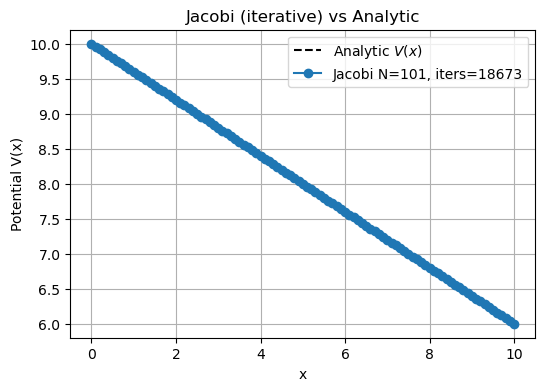

Converged: True, iterations: 18673
Mean abs error: 6.381e-04, Max abs error: 1.013e-03


In [5]:
# Set up conditions to run the function 
d = 10      # distance in m 
V_0 = 10    # initial potential in V
V_d = 6     # final potential in V
N = 101       # number of points to include 

# Call the jacobi function to get our x and V arrays 
x_num, V_num, iters, conv = jacobi_1d(N, d, V_0, V_d, max_iter=20000, tol=1e-6, verbose=True)

# plot the analytical solution for comparison
x_analytic = np.linspace(0, d, N)
V_exact = V_0 + (V_d - V_0) * (x_analytic / d)

# plot and compare numerical and analytical solutions on a plot 
plt.figure(figsize=(6,4))
plt.plot(x_analytic, V_exact, 'k--', label='Analytic $V(x)$')
plt.plot(x_num, V_num, 'o-', label=f'Jacobi N={N}, iters={iters}')
plt.xlabel('x')
plt.ylabel('Potential V(x)')
plt.legend()
plt.grid(True)
plt.title('Jacobi (iterative) vs Analytic')
plt.show()

# error metrics (interpolate analytic to numeric x)
V_exact_at_num = V_0 + (V_d - V_0) * (x_num / d)
abs_err = np.abs(V_num - V_exact_at_num)
print(f"Converged: {conv}, iterations: {iters}")
print(f"Mean abs error: {abs_err.mean():.3e}, Max abs error: {abs_err.max():.3e}")

## Discussion

We can see that the analytical solution gives a straight line in potential between the 2 boundary conditions. The numerical solution does also correctly converge to this. This is a rather simple case of using a Jacobi Iterative solver to display an analytical solution since the anlalytical solution is quite trivial.